In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def run_simulations(tau, num_trials):
    
    
    def estBetaParams(mu, var):
        alpha=((1 - mu) / var - 1 / mu) * mu**2
        beta=alpha * (1 / mu - 1)
        return alpha,beta

    def estGammaParams(mu,var):
        shape=(mu**2)/var
        scale=var/mu
        return shape, scale
    
        #Non-Stochastic Parameters Parameters

    N = 10**6           #250000               # Total population
    p_3months = 0.3          # Proportion tested every 3 months
    p_12months = 1-p_3months         # Proportion tested every 12 months
   

    # The (weighted) average testing proportion for our population (proportion per day)
    average_daily_testing_proportion = (p_3months/91 + p_12months/365)
    tests_per_day=N*average_daily_testing_proportion
    
    #How does test sensitivity/specificity fit in? Specificity should be irrelevent because we are concerned with 
    #routine testing. Low sensitivity should add a flow from A_t back into A_u or something like that (i.e. people who
    # receive a false negative (apparently quite a high probability for asymptomatic individuals))
    
    
    # I think that the generic person will get tested with this probability each day, and so the waiting
    # time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
    # No.... maybe it should be with rate tests_per_day??
    
    #Future goals: Stratify according to sexual activity levels. The current rate of partner exchange seems 
    #.             insufficient to completely capture the dynamics. 
    
    

    # Initial conditions
    E0 = 0.10 * N             # Initial exposed individuals.
    X0 = N - E0              # Initial susceptible individuals.
    S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
    A_u0 = 0               # Initial asymptomatic individuals who are untested.
    A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
    A_pos0 = 0              # Initial asympt. positive test. These people are isolating. 
    A_neg0 = 0                   # Initial asymptomatic people with a false negative 
        
        
    #Define the Model 

    def model(Y, t, beta, ppd, sensitivity, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):


        X, E, S, A_u, A_t, A_pos, A_neg= Y


        # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
        dXdt = -beta*ppd*X*(A_u+A_t+A_neg)/N + gamma_t*S  + gamma_t*A_pos + (1-theta)*gamma_u*A_u + (1-theta)*gamma_u*A_t + (1-theta)*gamma_u*A_neg


        dEdt = beta*ppd*X*(A_u+A_t+A_neg)/N - epsilon*E


        dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u + theta*gamma_u*A_t + theta*gamma_u*A_neg - gamma_t*S 


        dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u
        
        
        dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t


        dA_posdt = sensitivity*omega_r*A_t - gamma_t*A_pos
        
        
        dA_negdt = (1-sensitivity)*omega_r*A_t - gamma_u*A_neg




        return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt, dA_negdt]

    t_points = np.linspace(0, 30 * 365, 30 * 365) #30 years


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6


    solutions=np.zeros((num_trials,len(t_points), 7))
    sim_params=np.zeros((num_trials, len(t_points),9))

    for i in range(num_trials):
        solutions[i][0]= [X0, E0, S0, A_u0, A_t0, A_pos0,A_neg0]
        
    # Run Simulations

    for i in range(num_trials):
        for j in range(1, len(t_points)):



            #Stochastic params
            
            # Infection rate is 85% probability of infection per act(drawn from a beta dist) 
            beta = np.random.beta(estBetaParams(0.85,0.1)[0],estBetaParams(0.85,0.1)[1])
            
            #number of partners per day drawn from a gamma dist with mean =4 (per month) resclaled to 30 days. 
            # This seems a bit high but not unusual for particularly active groups of GBMSM people
            # Note, a higher variance may be appropriate here. 
            ppd = np.random.gamma(estGammaParams(3,3)[0],estGammaParams(3,3)[1])/30   
            
            # Inverse of the latency period post infection. Latency estimated to be gamma with mean 5 days
            epsilon = 1/(np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001)  
            
            # Clearance rate with treatment. Infection is usually assumed to be resolved in an average of 
            # 7 days with standard treatment
            gamma_t = 1/(np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1])+0.00000000000001) 
            
            # Clearance rate for untreated individuals. We assume that most (asymptomatic) individuals will self-clear
            # in around two weeks, or else become symptomatic. Note the higher variance. 
            gamma_u = 1/(np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001)
            
            theta = np.random.beta(estBetaParams(0.1,0.01)[0],estBetaParams(0.1,0.01)[1])
             
            lambda_ = np.random.beta(estBetaParams(0.9,0.01)[0],estBetaParams(0.9,0.01)[1]) 
            
            omega_r = 1/(np.random.gamma(estGammaParams(tau,1)[0], estGammaParams(tau,1)[1])+0.00000000000001)
            
            sensitivity = np.random.beta(estBetaParams(0.6,0.1)[0], estBetaParams(0.6,0.1)[1])
            

            #record these for average yearly rates later.
            sim_params[i][j]=[beta,ppd,sensitivity, epsilon,gamma_t,theta,gamma_u,lambda_,omega_r]


            tspan = [t_points[j-1], t_points[j]]

            ys = odeint(model, solutions[i][j-1], tspan, args=(beta, ppd, sensitivity, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)

             # Update the solution
            solutions[i][j] = ys[-1]
            #print(i,j, solutions[i][j], sum(solutions[i][j]))


           # Initialize lists to store totals for each simulation
    total_infections_per_simulation = []
    total_detected_cases_per_simulation = []
    percent_detected_cases_per_simulation = []

    for i in range(num_trials):
        # Extract the last year's data for this simulation
        last_year_data = solutions[i][-365:]#/N ###MAKE SURE THIS DOESNT WRECK THINGS
        last_year_params = sim_params[i][-365:]

        # Initialize variables to store the sum of daily inflows
        sum_daily_inflow_E = 0
        sum_daily_inflow_S = 0
        sum_daily_inflow_A_pos = 0

        # Calculate daily inflow rates for the last year of this simulation
        for day_data, day_params in zip(last_year_data, last_year_params):
            X, E, S, A_u, A_t, A_pos, A_neg = day_data
            beta,ppd, sensitivity, epsilon, gamma_t, theta, gamma_u, lambda_, omega_r = day_params

            # Compute daily inflow rates
            # Note: these are the only relevant flows because we are only considering a case to be 
            #       detected if it is symptomatic or receives a positive asymptomatic test
            daily_inflow_E = beta* ppd * X * (A_u + A_t + A_neg) / N
            daily_inflow_S = (1 - lambda_) * epsilon * E + theta * gamma_u * A_u + theta*gamma_u*A_t +theta*gamma_u*A_neg
            daily_inflow_A_pos = sensitivity*omega_r*A_t

            # Sum the inflows
            sum_daily_inflow_E += daily_inflow_E
            sum_daily_inflow_S += daily_inflow_S
            sum_daily_inflow_A_pos += daily_inflow_A_pos

        # Calculate total yearly inflow for each compartment
        total_yearly_inflow_E = sum_daily_inflow_E
        total_yearly_inflow_S = sum_daily_inflow_S
        total_yearly_inflow_A_pos = sum_daily_inflow_A_pos

        # Total infections for the last year
        total_infections_last_year = total_yearly_inflow_E

        # Total Detected Cases 
        total_detected_cases = total_yearly_inflow_S + total_yearly_inflow_A_pos
        
        # Percent Detected Cases
        percent_detected_cases = total_detected_cases/total_infections_last_year

        # Store the totals for each simulation
        total_infections_per_simulation.append(total_infections_last_year)
        total_detected_cases_per_simulation.append(total_detected_cases)
        percent_detected_cases_per_simulation.append(percent_detected_cases)

    # Calculate the stats across all simulations
    
    #now compute averages accross all simulations:
    from scipy import stats
    average_total_infections = np.mean(total_infections_per_simulation)
    stdev_total_infections=np.std(total_infections_per_simulation)
    conf_total_infections=stats.norm.interval(0.95,loc=average_total_infections,scale=stdev_total_infections/np.sqrt(num_trials))
    upper_conf_bound_total_infections= average_total_infections+stats.norm.ppf(1-.05)*stdev_total_infections/np.sqrt(num_trials)
    total_infection_stats=[average_total_infections,stdev_total_infections, conf_total_infections, upper_conf_bound_total_infections]
    
    average_total_detected_cases = np.mean(total_detected_cases_per_simulation)
    stdev_total_detected_cases=np.std(total_detected_cases_per_simulation)
    conf_total_detected_cases=stats.norm.interval(0.95,loc=average_total_detected_cases,scale=stdev_total_detected_cases/np.sqrt(num_trials))
    upper_conf_bound_total_detected_cases = average_total_detected_cases+ stats.norm.ppf(1-.05)*stdev_total_detected_cases/np.sqrt(num_trials)
    total_detected_cases_stats=[average_total_detected_cases,stdev_total_detected_cases, conf_total_detected_cases,upper_conf_bound_total_detected_cases]
    
    average_percent_detected_cases = np.mean(percent_detected_cases_per_simulation)
    stdev_percent_detected_cases = np.std(percent_detected_cases_per_simulation)
    conf_percent_detected_cases = stats.norm.interval(0.95,loc=average_percent_detected_cases, scale=stdev_percent_detected_cases/np.sqrt(num_trials))
    upper_conf_bound_percent_detected_cases = average_percent_detected_cases + stats.norm.ppf(1-.05)*stdev_percent_detected_cases/np.sqrt(num_trials)
    percent_detected_cases_stats = [average_percent_detected_cases, stdev_percent_detected_cases, conf_percent_detected_cases, upper_conf_bound_percent_detected_cases]
   
    #Average Solution Scaled
    
    average_solution=np.mean(solutions, axis=0)/N



    return average_solution, total_infection_stats, total_detected_cases_stats, percent_detected_cases_stats

In [9]:
import pandas as pd
import time
import datetime

# Record the start time
start_time = time.time()


# Define the range of tau values
tau_values = np.arange(1,14,0.5)
num_trials = 1000  # Define the number of trials for each tau value


# Initialize lists to store results
results_mean = []
results_conf_intervals = []
average_solutions = []  # List to store average_solution for each tau

# DataFrame to store all results for CSV
all_results_df = pd.DataFrame()

now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d_%H%M%S")  # Format the datetime
excel_filename = f'simulation_results_detailed_{num_trials}_{formatted_now}.xlsx'


for tau in tau_values: 
    print(tau)
    
    # Run simulations for each tau
    average_solution, total_infection_stats, total_detected_cases_stats, percent_detected_cases_stats = run_simulations(tau, num_trials)
    average_solutions.append(average_solution[-365:])
    
    # Store the results
    results_mean.append((total_infection_stats[0], total_detected_cases_stats[0],percent_detected_cases_stats[0]))
    results_conf_intervals.append((total_infection_stats[2], total_detected_cases_stats[2],percent_detected_cases_stats[2]))

    # Prepare data for CSV
    temp_df = pd.DataFrame({
        'Tau': tau,
        'Average Total Infections': total_infection_stats[0],
        'Infections Std Dev': total_infection_stats[1],
        'Infections Conf Interval Lower': total_infection_stats[2][0],
        'Infections Conf Interval Upper': total_infection_stats[2][1],
        'Upper Confidence Bound, Total Infections': total_infection_stats[3],
        'Average Total Detected Cases': total_detected_cases_stats[0],
        'Detected Cases Std Dev': total_detected_cases_stats[1],
        'Detected Cases Conf Interval Lower': total_detected_cases_stats[2][0],
        'Detected Cases Conf Interval Upper': total_detected_cases_stats[2][1],
        'Upper Confidence Bound, Total Detected Cases': total_detected_cases_stats[3],
        'Average Percent Detected Cases': percent_detected_cases_stats[0],
        'Percent Detected Cases Std Dev': percent_detected_cases_stats[1],
        'Percent Detected Conf Interval Lower': percent_detected_cases_stats[2][0],
        'Percent Detected Conf Interval Upper': percent_detected_cases_stats[2][1],
        'Upper Confidence Bound, Percent Detected Cases': percent_detected_cases_stats[3]
        
    }, index=[0])
    all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)
    
    


end_time = time.time()


## Create an Excel writer using pandas outside the loop
#with pd.ExcelWriter(excel_filename) as writer:
    # Save the summarized results to the first sheet
#    all_results_df.to_excel(writer, sheet_name='Summary', index=False)

    # Iterate over each tau value and its corresponding average_solution
#    for index, tau in enumerate(tau_values):
#        avg_sol_last_year_df = pd.DataFrame(average_solutions[index].T, columns=['X', 'E', 'S', 'A_u', 'A_t', 'A_pos'])
#        sheet_name = f'Tau_{tau}'
#        avg_sol_last_year_df.to_excel(writer, sheet_name=sheet_name, index=False)

#print(f"Data saved to {excel_filename}")



# Calculate and print the runtime
runtime = end_time - start_time
print(f"The runtime of the code is {runtime} seconds.")


1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
The runtime of the code is 49460.812821149826 seconds.


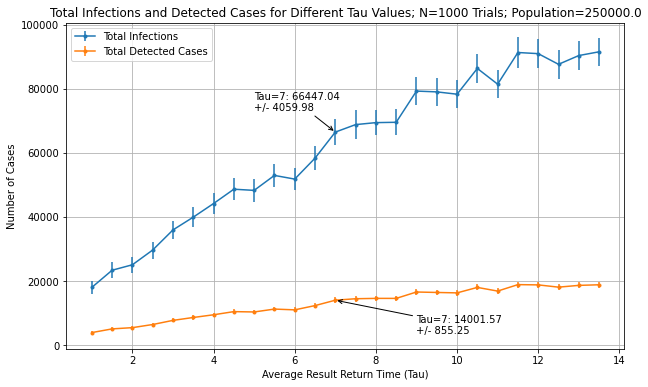

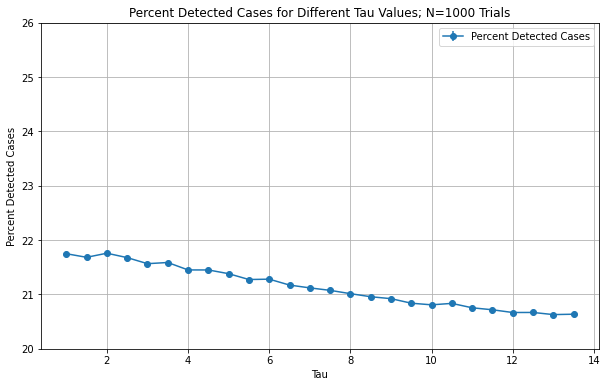

In [10]:
# Convert results for plotting


N=10**6
pop_scaler = 250000 / N

# Get current datetime
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d_%H%M%S")  # Format the datetime

# Unpack the results_mean into separate lists
infections_mean, detected_mean, percent_detected_mean = zip(*results_mean)

# Scale the mean values (total infections and detected cases) by the pop_scaler
infections_mean = [mean * pop_scaler for mean in infections_mean]
detected_mean = [mean * pop_scaler for mean in detected_mean]

# Scale the confidence intervals
infections_conf, detected_conf, percent_detected_conf = zip(*[[(conf[0] * pop_scaler, conf[1] * pop_scaler) for conf in interval] for interval in results_conf_intervals])

# Recalculate the errors for scaled data
infections_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(infections_mean, infections_conf)]
detected_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(detected_mean, detected_conf)]

# Calculate the errors for percent detected cases (no scaling needed)
percent_detected_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(percent_detected_mean, percent_detected_conf)]


# Find the index for tau = 7 in the numpy array
tau_7_index = np.where(tau_values == 7)[0][0]  # This will give the index of the first occurrence of tau = 7


# Get the mean and error values for tau = 7
infections_mean_7 = infections_mean[tau_7_index]
detected_mean_7 = detected_mean[tau_7_index]
infections_error_7 = infections_error[tau_7_index]
detected_error_7 = detected_error[tau_7_index]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(tau_values, infections_mean, yerr=np.array(infections_error).T, label='Total Infections', fmt='-o', markersize=3)
plt.errorbar(tau_values, detected_mean, yerr=np.array(detected_error).T, label='Total Detected Cases', fmt='-o', markersize=3)

# Annotations for tau = 7
plt.annotate(f'Tau=7: {infections_mean_7:.2f}\n+/- {infections_error_7[1]:.2f}',
             xy=(7, infections_mean_7), xytext=(5, infections_mean_7 * 1.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Tau=7: {detected_mean_7:.2f}\n+/- {detected_error_7[1]:.2f}',
             xy=(7, detected_mean_7), xytext=(9, detected_mean_7 * 0.25),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.xlabel('Average Result Return Time (Tau)')
plt.ylabel('Number of Cases')
plt.title(f"Total Infections and Detected Cases for Different Tau Values; N={num_trials} Trials; Population={N*pop_scaler}")
plt.legend()
plt.grid(True)

# Create a dynamic file name
filename = f"num_trials_{num_trials}_{formatted_now}.png"

# Save the plot with the dynamic file name
plt.savefig(filename)

plt.show()


# Calculate the errors for percent detected cases
percent_detected_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(percent_detected_mean, percent_detected_conf)]
percent_detected_error = [(100*err[0],100*err[1]) for err in percent_detected_error]

# Plotting the percent detected cases
plt.figure(figsize=(10, 6))
plt.errorbar(tau_values, [100* prop for prop in percent_detected_mean], yerr=np.array(percent_detected_error).T, label='Percent Detected Cases', fmt='-o')
plt.xlabel('Tau')
plt.ylabel('Percent Detected Cases')                  
plt.title(f"Percent Detected Cases for Different Tau Values; N={num_trials} Trials")
plt.ylim(20,26)
plt.legend()
plt.grid(True)

# Create a dynamic file name for the percent detected cases plot
filename_percent = f"percent_detected_{num_trials}_{formatted_now}.png"

# Save the plot with the dynamic file name
plt.savefig(filename_percent)

plt.show()



In [7]:
N=10**6
pop_scaler = 250000 / N

# Get current datetime
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d_%H%M%S")  # Format the datetime

# Scale the mean values and confidence intervals
infections_mean, detected_mean = zip(*[(mean * pop_scaler, detected * pop_scaler) for mean, detected in results_mean])
infections_conf, detected_conf = zip(*[[(conf[0] * pop_scaler, conf[1] * pop_scaler) for conf in interval] for interval in results_conf_intervals])

# Recalculate the errors
infections_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(infections_mean, infections_conf)]
detected_error = [(mean - conf[0], conf[1] - mean) for mean, conf in zip(detected_mean, detected_conf)]

# Find the index for tau = 7 in the numpy array
tau_7_index = np.where(tau_values == 7)[0][0]  # This will give the index of the first occurrence of tau = 7


# Get the mean and error values for tau = 7
infections_mean_7 = infections_mean[tau_7_index]
detected_mean_7 = detected_mean[tau_7_index]
infections_error_7 = infections_error[tau_7_index]
detected_error_7 = detected_error[tau_7_index]

# Plotting the results with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

plt.title(f"Total Infections and Detected Cases for Different Tau Values; N={num_trials} Trials; Population={N*pop_scaler}")

# First y-axis for Total Infections
ax1.errorbar(tau_values, infections_mean, yerr=np.array(infections_error).T, label='Total Infections', fmt='-o', color='red')
ax1.set_xlabel('Tau')
ax1.set_ylabel('Number of Infections', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Second y-axis for Detected Cases
ax2 = ax1.twinx()  
ax2.errorbar(tau_values, detected_mean, yerr=np.array(detected_error).T, label='Total Detected Cases', fmt='-o', color='blue')
ax2.set_ylabel('Number of Detected Cases', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Annotations for tau = 7 with adjusted positions
ax1.annotate(f'Infections: {infections_mean_7:.2f}\n+/- {infections_error_7[1]:.2f}',
             xy=(7, infections_mean_7), xytext=(5, infections_mean_7 * 1.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             color='red')

ax2.annotate(f'Detected: {detected_mean_7:.2f}\n+/- {detected_error_7[1]:.2f}',
             xy=(7, detected_mean_7), xytext=(8, detected_mean_7 * 0.8),
             arrowprops=dict(facecolor='blue', arrowstyle='->'),
             color='blue')

# Create a dynamic file name
filename = f"num_trials_{num_trials}_{formatted_now}.png"

# Save the plot with the dynamic file name
plt.savefig(filename)

plt.show()



ValueError: too many values to unpack (expected 2)

In [8]:
# Save results to a CSV file
scaled_all_results_df = all_results_df * pop_scaler
scaled_all_results_df.to_csv(f'simulation_results_corrected_confidence_intervals_num_trials_{num_trials}_{formatted_now}.csv', index=False)